# Preentrenamiento del modelo especializado en matrículas.

In [4]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

results = model.train(
  data="data.yaml",
  epochs=100,
  imgsz=640,
  batch=4,
  patience=50,
  device=0
)

New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.9.23 torch-2.8.0+cu126 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize

## Detección en vídeo.

In [ ]:
from ultralytics import YOLO 
import cv2
import csv
import easyocr

print("Cargando modelos en GPU...")
vehicle_model = YOLO('yolo11n.pt').to('cuda:0')
plate_model = YOLO('runs/detect/train5/weights/best.pt').to('cuda:0')

try:
    reader_ocr = easyocr.Reader(['es', 'en'], gpu=True) 
    print("EasyOCR cargado en GPU.")
except Exception as e:
    print(f"No se pudo cargar EasyOCR en GPU ({e}), cargando en CPU...")
    reader_ocr = easyocr.Reader(['es', 'en'], gpu=False)
    print("EasyOCR cargado en CPU.")


vid_route = "./img/03112025_2.mp4"
video_out_path = "./results/resultado_practica3.mp4"
csv_out_path = "./results/resultado_practica3.csv"
csv_data = []

# 0: persona, 2: coche, 5: bus, 7: camión
classes_to_detect = [0, 2, 5, 7] 

cap = cv2.VideoCapture(vid_route)
if not cap.isOpened():
    print(f"Error: No se pudo abrir el video '{vid_route}'")
    exit()

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
DISPLAY_WIDTH = 1280 
aspect_ratio = frame_height / frame_width
DISPLAY_HEIGHT = int(DISPLAY_WIDTH * aspect_ratio)

fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out_video = cv2.VideoWriter(video_out_path, fourcc, fps, (frame_width, frame_height))

frame_number = 0
total_vehicles = set()
total_people = set()
total_plates = 0 

# Listas para el procesamiento por lotes
vehicle_rois = []
vehicle_data_batch = []

while True: 
    ret, frame = cap.read()
    if not ret: 
        print("THE END")
        break
    
    frame_number += 1
    
    # Limpiamos las listas en cada fotograma
    vehicle_rois.clear()
    vehicle_data_batch.clear()

    resultados = vehicle_model.track(
      frame,
      classes=classes_to_detect,
      imgsz=640,
      conf=0.6,
      verbose=False,
      device=0,  # Forzar GPU
      persist=True # Mantener el seguimiento entre fotogramas
    )


    if resultados[0].boxes.id is not None:
        for i, box in enumerate(resultados[0].boxes):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls = int(box.cls[0])
            obj_type = vehicle_model.names[cls] 
            conf = float(box.conf[0])
            track_id = int(resultados[0].boxes.id[i])

            csv_row = [frame_number, obj_type, conf, track_id, x1, y1, x2, y2, '', '', '', '', '', '', '']

            if obj_type == "person":
                total_people.add(track_id)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2) 
                label = f'P: {track_id}' 
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                csv_data.append(csv_row)
            
            elif obj_type in ["car", "bus", "truck"]:
                total_vehicles.add(track_id)

                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                label = f'V: {track_id}'
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                
                img_vehiculo = frame[y1:y2, x1:x2]
                if img_vehiculo.size > 0:
                    vehicle_rois.append(img_vehiculo)
                    vehicle_data_batch.append((csv_row, (x1, y1)))

    if vehicle_rois:
        results_plates = plate_model.track(
            vehicle_rois, 
            conf=0.6,
            imgsz=320,
            verbose=False,
            device=0,
            persist=True
        )
        
        for i, result_plate in enumerate(results_plates):
            csv_row, (x1_v, y1_v) = vehicle_data_batch[i]
            
            if result_plate.boxes is not None:
                for box_placa in result_plate.boxes:
                    
                    total_plates += 1 
                
                    px1, py1, px2, py2 = map(int, box_placa.xyxy[0])
                    placa_conf = float(box_placa.conf[0])
                    
                    abs_px1 = px1 + x1_v
                    abs_py1 = py1 + y1_v
                    abs_px2 = px2 + x1_v
                    abs_py2 = py2 + y1_v
                    
                    # OCR
                    img_placa_recortada = frame[abs_py1:abs_py2, abs_px1:abs_px2]
                    texto_matricula = ""
                    if img_placa_recortada.size > 0:
                        ocr_results = reader_ocr.readtext(img_placa_recortada, detail=0, paragraph=True)
                        if ocr_results:
                            texto_matricula = "".join(ocr_results).upper()
                            texto_matricula = "".join(filter(str.isalnum, texto_matricula))
                            
                    
                    color_placa = (0, 255, 0)
                    cv2.rectangle(frame, (abs_px1, abs_py1), (abs_px2, abs_py2), color_placa, 2)
                    label_placa = f"{texto_matricula} ({placa_conf:.2f})"
                    cv2.putText(frame, label_placa, (abs_px1, abs_py1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_placa, 2)
                    
                    csv_row[8] = 'matricula'
                    csv_row[9] = placa_conf
                    csv_row[10] = abs_px1
                    csv_row[11] = abs_py1
                    csv_row[12] = abs_px2
                    csv_row[13] = abs_py2
                    csv_row[14] = texto_matricula
                    break 
            
            csv_data.append(csv_row)

    out_video.write(frame)
    
    display_frame = cv2.resize(frame, (DISPLAY_WIDTH, DISPLAY_HEIGHT), interpolation=cv2.INTER_AREA)
    cv2.imshow("Prototipo Final (Pipeline de 2 Modelos)", display_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out_video.release()
cv2.destroyAllWindows()

header = ['fotograma', 'tipo_objeto', 'confianza', 'identificador_tracking', 
          'x1', 'y1', 'x2', 'y2', 'matrícula_en_su_caso', 'confianza_matricula', 
          'mx1', 'my1', 'mx2', 'my2', 'texto_matricula']

try:
    with open(csv_out_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(csv_data)
    print(f"\nDatos CSV guardados exitosamente en {csv_out_path}")
except PermissionError:
    print(f"\nError: Permiso denegado. No se pudo escribir en {csv_out_path}.")

print(f"Vídeo de salida guardado en {video_out_path}")
print(f"Procesamiento finalizado.")
print(f"Total de personas únicas: {len(total_people)}")
print(f"Total de vehículos únicos: {len(total_vehicles)}")
print(f"Total de detecciones de matrícula: {total_plates}") 

Cargando modelos en GPU...
EasyOCR cargado en GPU.
THE END

Datos CSV guardados exitosamente en ./results/resultado_practica3.csv
Vídeo de salida guardado en ./results/resultado_practica3.mp4
Procesamiento finalizado.
Total de personas únicas: 1
Total de vehículos únicos: 24
Total de detecciones de matrícula: 0


## Detección en imagen

### OCR en IMAGEN

In [10]:
from ultralytics import YOLO 
import cv2
import easyocr
import time

vehicle_model = YOLO('yolo11n.pt')

plate_model = YOLO('runs/detect/train5/weights/best.pt')


try:
    reader_ocr = easyocr.Reader(['es', 'en'], gpu=True) 
    print("EasyOCR cargado en GPU.")
except:
    reader_ocr = easyocr.Reader(['es', 'en'], gpu=False)
    print("EasyOCR cargado en CPU.")

classes_to_detect = [0, 2, 5, 7] 

frame = cv2.imread("img/prueba4.jpg")
if frame is None:
  print("No se pudo detectar la imagen")
  exit()

resultados = vehicle_model(
  frame,
  classes=classes_to_detect,
  conf=0.4,
  verbose=False
)

detection_count = 0

if resultados[0].boxes is not None:
    for box in resultados[0].boxes:
        detection_count += 1
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls[0])
        currentClass = vehicle_model.names[cls] 
        confidence = box.conf[0]

        color_vehiculo = (255, 0, 0) 
        cv2.rectangle(frame, (x1, y1), (x2, y2), color_vehiculo, 2)
        label = f'{currentClass} {confidence:.2f}'
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_vehiculo, 2)

        img_vehiculo = frame[y1:y2, x1:x2]
        if img_vehiculo.size == 0: continue

        results_placa = plate_model(img_vehiculo, conf=0.5, verbose=False)

        if results_placa[0].boxes is not None:
            for box_placa in results_placa[0].boxes:
                px1, py1, px2, py2 = map(int, box_placa.xyxy[0])
                placa_conf = box_placa.conf[0]
                
                abs_px1 = px1 + x1
                abs_py1 = py1 + y1
                abs_px2 = px2 + x1
                abs_py2 = py2 + y1
                
                img_placa_recortada = frame[abs_py1:abs_py2, abs_px1:abs_px2]
                texto_matricula = ""
                
                if img_placa_recortada.size > 0:
                    ocr_results = reader_ocr.readtext(img_placa_recortada, detail=0, paragraph=True)
                    if ocr_results:
                        texto_matricula = "".join(ocr_results).upper()
                        texto_matricula = "".join(filter(str.isalnum, texto_matricula))
                
                color_placa = (0, 255, 0) 
                cv2.rectangle(frame, (abs_px1, abs_py1), (abs_px2, abs_py2), color_placa, 2)
                
                label_final_placa = f"{texto_matricula} ({placa_conf:.2f})"
                cv2.putText(frame, label_final_placa, (abs_px1, abs_py1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_placa, 2)

frame_height, frame_width = frame.shape[:2]
DISPLAY_WIDTH = 900
if frame_width > DISPLAY_WIDTH:
    aspect_ratio = frame_height / frame_width
    DISPLAY_HEIGHT = int(DISPLAY_WIDTH * aspect_ratio)
    display_frame = cv2.resize(frame, (DISPLAY_WIDTH, DISPLAY_HEIGHT), interpolation=cv2.INTER_AREA)
else:
    display_frame = frame

cv2.imwrite("resultado.png", display_frame)
print("Imagen procesada guardada como resultado.png")
cv2.imshow("Deteccion en Imagen (Vehiculos y Matriculas)", display_frame)
print("Presiona cualquier tecla para cerrar la ventana.")
cv2.waitKey(0) 
cv2.destroyAllWindows()
print("Ventana cerrada.")

EasyOCR cargado en GPU.
Imagen procesada guardada como resultado.png
Presiona cualquier tecla para cerrar la ventana.
Ventana cerrada.


## Comparativa OCR

In [ ]:
from ultralytics import YOLO 
import cv2
import easyocr
import pytesseract  
import time
import pandas as pd 
import os            

try:
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
except FileNotFoundError:
    print("Aviso: Tesseract no se encontró en 'C:\\Program Files\\Tesseract-OCR\\'.")
    print("Asegúrate de que esté instalado y/o en el PATH.")

vehicle_model = YOLO('yolo11n.pt')

try:
    plate_model = YOLO('runs/detect/train5/weights/best.pt') 
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'runs/detect/train3/weights/best.pt'")
    print("Por favor, pon la ruta correcta a tu modelo de matrículas entrenado.")
    exit()


print("Forzando carga de EasyOCR en CPU.")
reader_ocr = easyocr.Reader(['es', 'en'], gpu=False)

classes_to_detect = [0, 2, 5, 7] 

IMAGE_FOLDER_PATH = "matriculas/test/images" 
CSV_OUTPUT_FILE = "results/comparativa_ocr.csv"

# Lista para guardar todos los resultados
all_results = []

print(f"Iniciando comparativa en la carpeta: {IMAGE_FOLDER_PATH}...")

if not os.path.exists(IMAGE_FOLDER_PATH):
    print(f"ERROR: La carpeta de imágenes no existe: {IMAGE_FOLDER_PATH}")
    exit()

for image_name in os.listdir(IMAGE_FOLDER_PATH):
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    image_path = os.path.join(IMAGE_FOLDER_PATH, image_name)
    frame = cv2.imread(image_path)
    
    if frame is None:
        print(f"Advertencia: No se pudo leer la imagen {image_path}. Saltando.")
        continue

    print(f"Procesando: {image_name}")

    resultados = vehicle_model(
        frame,
        classes=classes_to_detect,
        conf=0.4,
        verbose=False
    )

    if resultados[0].boxes is not None:
        for box in resultados[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            img_vehiculo = frame[y1:y2, x1:x2]
            if img_vehiculo.size == 0: continue

            results_placa = plate_model(img_vehiculo, conf=0.5, verbose=False)

            if results_placa[0].boxes is not None:
                for box_placa in results_placa[0].boxes:
                
                    px1, py1, px2, py2 = map(int, box_placa.xyxy[0])
                    placa_conf = float(box_placa.conf[0])
                    
                    abs_px1 = px1 + x1
                    abs_py1 = py1 + y1
                    abs_px2 = px2 + x1
                    abs_py2 = py2 + y1
                    
                    img_placa_recortada = frame[abs_py1:abs_py2, abs_px1:abs_px2]
                    
                    texto_easyocr = ""
                    tiempo_easyocr = 0.0
                    texto_tesseract = ""
                    tiempo_tesseract = 0.0

                    if img_placa_recortada.size > 0:
                        
                        # A. PRUEBA CON EASYOCR
                        start_time = time.time()
                        ocr_results = reader_ocr.readtext(img_placa_recortada, detail=0, paragraph=True)
                        tiempo_easyocr = time.time() - start_time
                        if ocr_results:
                            texto_easyocr = "".join(ocr_results).upper()
                            texto_easyocr = "".join(filter(str.isalnum, texto_easyocr))

                        # B. PRUEBA CON TESSERACT
                        gray_placa = cv2.cvtColor(img_placa_recortada, cv2.COLOR_BGR2GRAY)
                        _, th_placa = cv2.threshold(gray_placa, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                        
                        start_time = time.time()
                        config = '--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
                        texto_tesseract = pytesseract.image_to_string(th_placa, config=config)
                        tiempo_tesseract = time.time() - start_time
                        texto_tesseract = "".join(filter(str.isalnum, texto_tesseract.strip()))

                    # Resultados
                    all_results.append({
                        'imagen': image_name,
                        'conf_matricula': placa_conf,
                        'texto_easyocr': texto_easyocr,
                        'tiempo_easyocr': tiempo_easyocr,
                        'texto_tesseract': texto_tesseract,
                        'tiempo_tesseract': tiempo_tesseract
                    })

                    break

# Guardar CSV
if not all_results:
    print("\nAdvertencia: No se detectó ninguna matrícula en ninguna imagen. El archivo CSV estará vacío.")
else:
    df = pd.DataFrame(all_results)
    df.to_csv(CSV_OUTPUT_FILE, index=False, encoding='utf-8')
    print(f"\n¡Proceso completado!")
    print(f"Resultados de la comparativa guardados en: {CSV_OUTPUT_FILE}")

Forzando carga de EasyOCR en CPU.
Iniciando comparativa en la carpeta: matriculas/test/images...
Procesando: 0116GPD_2959_aug3.jpg
Procesando: 0116GPD_aug1.jpg
Procesando: 0116HGV.jpg
Procesando: 0290KWT_8386_aug3.jpg
Procesando: 0290KWT_aug3.jpg
Procesando: 0290KWT_aug5.jpg
Procesando: 0415JVS.jpeg
Procesando: 0416MLX.jpg
Procesando: 0416MLX_3562_aug2.jpg
Procesando: 0416MLX_3562_aug4.jpg
Procesando: 0476MNN_8798_aug2.jpg
Procesando: 0524MHT.jpg
Procesando: 0576MSH_7365_aug1.jpg
Procesando: 0576MSH_7365_aug5.jpg
Procesando: 0576MSH_aug2.jpg
Procesando: 0624LXM_3942_aug3.jpg
Procesando: 0624LXM_3942_aug4.jpg
Procesando: 0842GLN_7663_aug1.jpg
Procesando: 0842GLN_7663_aug5.jpg
Procesando: 0842GLN_aug1.jpg
Procesando: 0842GLN_aug2.jpg
Procesando: 0880DRN.jpg
Procesando: 0918LVY_3100_aug3.jpg
Procesando: 0918LVY_3100_aug4.jpg
Procesando: 0962LLT_2000_aug1.jpg
Procesando: 0962LLT_2000_aug3.jpg
Procesando: 0962LLT_aug1.jpg
Procesando: 1062FRF_165_aug5.jpg
Procesando: 1670JLN_aug3.jpg
Procesa

Columna 'matricula_real' generada con éxito.

--- CONCLUSIONES DE LA COMPARATIVA ---
Base de datos: 102 imágenes analizadas
----------------------------------------
[Tasa de Acierto (Precisión)]
  EasyOCR:   42.16% (43 de 102)
  Tesseract: 5.88% (6 de 102)

[Tiempo de Inferencia Medio (CPU)]
  EasyOCR:   0.0416 segundos
  Tesseract: 0.1291 segundos
----------------------------------------

Gráfica 'grafica_precision.png' guardada.


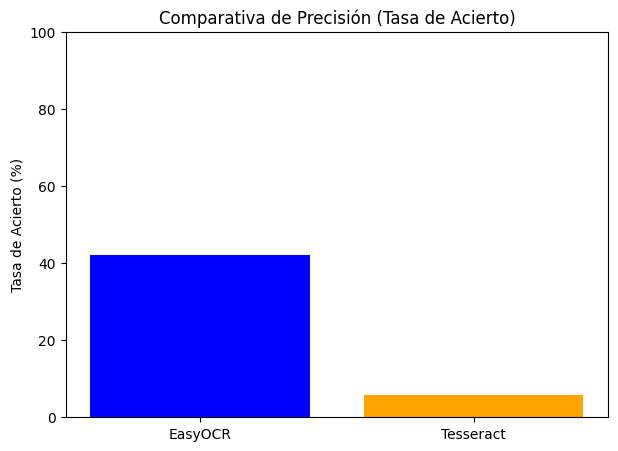

Gráfica 'grafica_tiempo.png' guardada.


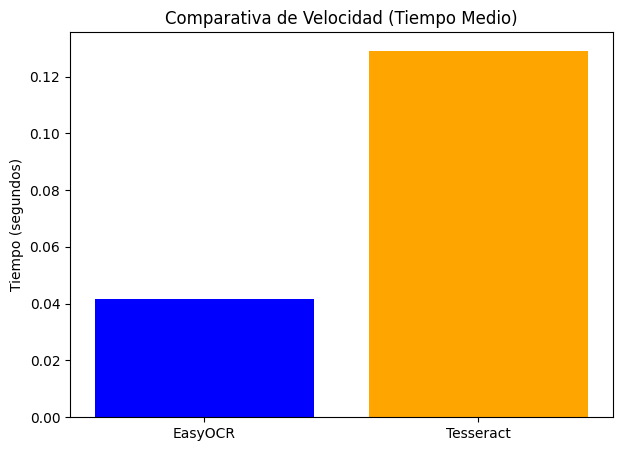

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


csv_file = 'results/comparativa_ocr.csv'
if not os.path.exists(csv_file):
    print(f"ERROR: No se encontró el archivo '{csv_file}'.")
else:
    df = pd.read_csv(csv_file)

    try:
        df['matricula_real'] = df['imagen'].str.split('[_\.]').str[0]
        print("Columna 'matricula_real' generada con éxito.")
    except Exception as e:
        print(f"Error generando la matrícula real: {e}")
        print("Asegúrate de que los nombres de archivo sean correctos.")
        exit()

    df['matricula_real'] = df['matricula_real'].fillna('').astype(str)
    df['texto_easyocr'] = df['texto_easyocr'].fillna('').astype(str)
    df['texto_tesseract'] = df['texto_tesseract'].fillna('').astype(str)

    # Calcular Tasa de Acierto
    
    # Limpiar los datos para una comparación justa
    df['matricula_real'] = df['matricula_real'].str.strip().str.upper()
    df['texto_easyocr'] = df['texto_easyocr'].str.strip().str.upper()
    df['texto_tesseract'] = df['texto_tesseract'].str.strip().str.upper()

    df_valid = df[df['matricula_real'] != '']
    
    aciertos_easyocr = (df_valid['texto_easyocr'] == df_valid['matricula_real']).sum()
    aciertos_tesseract = (df_valid['texto_tesseract'] == df_valid['matricula_real']).sum()
    total_imagenes = len(df_valid)

    if total_imagenes == 0:
        print("ERROR: No se pudo extraer ninguna matrícula real de los nombres de archivo.")
    else:
        tasa_easyocr = (aciertos_easyocr / total_imagenes) * 100
        tasa_tesseract = (aciertos_tesseract / total_imagenes) * 100

        # Calcular Tiempos Medios de Inferencia ---
        tiempo_easyocr = df['tiempo_easyocr'].mean()
        tiempo_tesseract = df['tiempo_tesseract'].mean()

        # Imprimir Conclusiones
        print("\n--- CONCLUSIONES DE LA COMPARATIVA ---")
        print(f"Base de datos: {total_imagenes} imágenes analizadas")
        print("----------------------------------------")
        print("[Tasa de Acierto (Precisión)]")
        print(f"  EasyOCR:   {tasa_easyocr:.2f}% ({aciertos_easyocr} de {total_imagenes})")
        print(f"  Tesseract: {tasa_tesseract:.2f}% ({aciertos_tesseract} de {total_imagenes})")
        print("\n[Tiempo de Inferencia Medio (CPU)]")
        print(f"  EasyOCR:   {tiempo_easyocr:.4f} segundos")
        print(f"  Tesseract: {tiempo_tesseract:.4f} segundos")
        print("----------------------------------------")

        # Generar Gráficas
        
        # Gráfica 1: Precisión
        modelos = ['EasyOCR', 'Tesseract']
        tasas = [tasa_easyocr, tasa_tesseract]
        
        plt.figure(figsize=(7, 5))
        plt.bar(modelos, tasas, color=['blue', 'orange'])
        plt.title('Comparativa de Precisión (Tasa de Acierto)')
        plt.ylabel('Tasa de Acierto (%)')
        plt.ylim(0, 100)
        
        plt.savefig('results/grafica_precision.png')
        print("\nGráfica 'grafica_precision.png' guardada.")
        plt.show() 

        # Gráfica 2: Velocidad
        tiempos = [tiempo_easyocr, tiempo_tesseract]
        
        plt.figure(figsize=(7, 5))
        plt.bar(modelos, tiempos, color=['blue', 'orange'])
        plt.title('Comparativa de Velocidad (Tiempo Medio)')
        plt.ylabel('Tiempo (segundos)')
        
        plt.savefig('results/grafica_tiempo.png')
        print("Gráfica 'grafica_tiempo.png' guardada.")
        plt.show()